# Shifting Spectra

Make sure you have apogee pointing to the right server path before running this! Sometimes the server location jumps around and tries to make you download all the data again.

In [3]:
#Importing the necessary packages
import apogee.tools.read as apread
import apogee.spec.plot as splot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
Lambda = splot.apStarWavegrid()
import csv

## EqW and Plotting Function

Here are the functions I use to calculate equivalent width and plot the spectra:

In [27]:
def find_nearest(array,value):
    index = (np.abs(array-value)).argmin()
    #return array[index]
    return index

In [28]:
def Brackett_EqW_Plot(loc_id, two_massid,number,left_limit,right_limit,bottom_limit,top_limit):
    spec_header = apread.apStar(loc_id, two_massid,ext=0,header=True)
    
    nvisits = spec_header[1]['NVISITS']
    n=number
    #calculate the emission line in a vacuum
    vhelio = spec_header[1]['VHELIO']
    doppler = spec_header[1]['VRAD1']
    bc1 = spec_header[1]['BC1']
    
    
    if nvisits == 1:
        spec1 = apread.apStar(loc_id, two_massid,ext=1,header=False)
    else:
        spec1 = apread.apStar(loc_id, two_massid,ext=1,header=False)[3]

    c = 299792
    rydberg = 1.0973731568539*(10**7)
    electron = 9.10938356*(10**-31)
    nucleus = 1.672621898*(10**-27)
    fracryd = rydberg/(1+(electron/nucleus))
    vacuum = fracryd*((1./16.)-(1./(float(n**2))))
    lambda_obs = 1/vacuum
    #calculated_point1 = lambda_obs*((1-(vhelio/c))/(1-(doppler/c)))
    #calculated_point1 = lambda_obs*(1-(bc1/c))
    #calculated_point1 = lambda_obs*(1-(vhelio/c))
    calculated_point1 = lambda_obs*(1-((vhelio)/c))
    diff2 = (lambda_obs-calculated_point1)*(10**10)
    calculated_point2 = calculated_point1*(10**10)
    
    
    
    centerline = find_nearest((Lambda+diff2),(lambda_obs*(10**10)))
    
    
        
    L1 = centerline - 135
    L2 = centerline - 90
    R1 = centerline + 90
    R2 = centerline + 135
    Lwindow = centerline - 160
    Rwindow = centerline + 160
    
    #Calculate Fc
    lsum= np.sum(spec1[L1:L2])/ len(spec1[L1:L2])
    rsum = np.sum(spec1[R1:R2])/len(spec1[R1:R2])
    Fc= (lsum+rsum)/2
    
    #Calculate Equivalent Width
    EqW=0
    for i in range(L2,R1):
        summ=(Fc*(Lambda[i+1]-Lambda[i]))-((1./2.)*(Lambda[i+1]-Lambda[i])*(spec1[i+1]+spec1[i]))
        EqW = EqW + summ
    EqW = abs(EqW/Fc)
    upper = Lambda[centerline]+(EqW/2)
    lower = Lambda[centerline]-(EqW/2)
    
    #Plot averaged spectrum with EqW
    fig,ax = plt.subplots(figsize=(16,8))
    plt.plot((Lambda+diff2),spec1,linewidth=2.5,label='Shifted')
    plt.plot(Lambda,spec1,linewidth=2.5,label='Unshifted')
    plt.axhline(y=Fc,ls='dashed',color='black')
    plt.axvline(x=Lambda[centerline]+diff2,ls='dashed',color='r',label='Rest Emission')
    plt.axvline(calculated_point2,ls=':',color='r',label='Star Emission')
    plt.legend()
    plt.xlabel('Wavelength'+' '+'('+ r'$\AA$'+')', fontsize=24)
    plt.ylabel('Flux (erg s' + r'$^{-1}$'+' cm'+r'$^{-2}$' + r'$\AA^{-1}$'+')', fontsize=24)
    plt.xlim(left_limit,right_limit)
    plt.ylim(bottom_limit,top_limit)
    
    ax.tick_params(axis='both', labelsize=20)

   

## APOGEE Data

#### Quick Notes

* The spectra from the APOGEE survey are given in vacuum wavelengths
* Each .fits file has at least one visit. If there is more than one visit then the first two arrays in the file are averaged spectra. To access an individual visit you will need to add an array value on the end when you call apread. For example:

In [7]:
loc_id = 4586
two_massid='2M03434449+3143092'
#For a file with only one visit 

header = apread.apStar(loc_id, two_massid,ext=0,header=True);
spec = apread.apStar(loc_id, two_massid,ext=1,header=False);

#For a file with more than one visit

header = apread.apStar(loc_id, two_massid,ext=0,header=True);
spec = apread.apStar(loc_id, two_massid,ext=1,header=False)[1]; 
#1-2 averaged spectrum, 3+ are individual  visits

* Vhelio is calculated and applied to each spectrum, shifting it into the star's rest frame

#### Radial Velocity and Vhelio 

Relative radial velocities (RVs) for each spectrum (i.e. between all the visits from the same star) are first calculated and then a mean value is calculated via an iterative process. This iterative process uses the highest S/N (signal-to-noise) spectrum as the base template and then compares relative RV values for all the visits until the differences converge to a mean value. Finding this mean value gives us a combined spectrum.  

This mean RV is then cross-correlated to the 'RV mini-grid' (538 synthetic spectra spanning a range for three stellar parameters: Teff, *log* g, and [Fe/H]) and a $\chi^2$ and best-fit RV values are calculated for each synthetic spectra. The lowest $\chi^2$ value is chosen and the respective best-fit RV is the absolute RV for the star.

Each visit's relative RV is then added to this absolute RV to get an absolute RV for each visit. A barycentric correction is applied to this absolute RV which brings the spectra into the heliocentric frame. This final RV is called Vhelio.

## Unshifted Plot

Below is the whole spectra plotted unshifted. Don't worry about the lines that go to zero; python isn't breaking there is just no recorded data there and I haven't told python not to plot them yet.

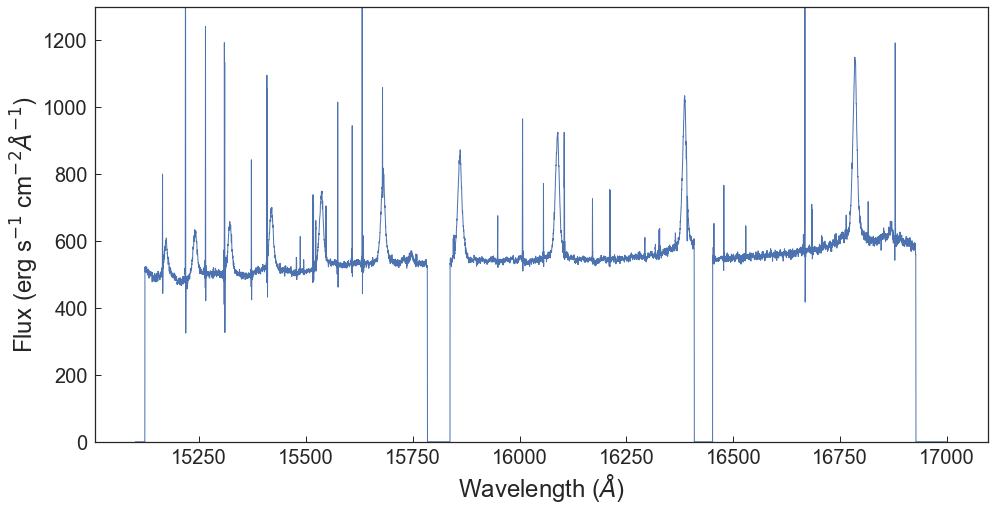

In [29]:
loc_id = 4586
two_massid='2M03434449+3143092'
spectest1 = apread.apStar(loc_id,two_massid,ext=1,header=False)[3]
fig,ax = plt.subplots(figsize=(16,8))
plt.plot(Lambda,spectest1,linewidth=1)
ax.tick_params(axis='both', labelsize=20)
plt.xlabel('Wavelength'+' '+'('+ r'$\AA$'+')', fontsize=24)
plt.ylabel('Flux (erg s' + r'$^{-1}$'+' cm'+r'$^{-2}$' + r'$\AA^{-1}$'+')', fontsize=24)
plt.ylim(0,1300);

## Applying Velocity Shift

First, we start out by getting some info from the header, namely the VHELIO parameter. We will use 2M03434449+3143092 as the example throughout this notebook. First, we need to pull down the header and access the second array (python starts the first array at [0] not [1]) to get the value for Vhelio.

Our desired value is VHELIO = 472.223. Since this value is positive it means that it is moving away from us and thus redshifted. The next step is to calculate the doppler shift for the observed Brackett 11 emission wavelength. To do this we need to use the Rydberg formula; normally we would use the general approximation that the nucleus' mass is infinite compared to the mass of an electron, i.e., the Rydberg constant. However, I believe that we need to use the reduced mass version of the constant (I figured this out just by playing around with the shifts).

#### *Note*: 

Latex doesn't always play nice with Github so if the following cells aren't rendering properly either download and run this notebook yourself or copy and paste the url into http://nbviewer.jupyter.org.

#### Calculating the rest wavelength

The formula for the wavelength of the Brackett 11 emission as measured in a lab (the rest wavelength) is given by $\frac{1}{\lambda}=R_M\left(\frac{1}{n_f^2}-\frac{1}{n_i^2}\right)$ where $R_M = R_{\infty}\left(1+\frac{m_e}{M}\right)^{-1}$ and M is the total mass of the nucleus. 

To calculate the reduced mass version of the Rydberg constant we do the following:

$$
R_M = R_{\infty}\left(1+\frac{m_e}{M}\right)^{-1} \\
R_{\infty} = 1.0973731568539\times10^7\text{ m}^{-1}\text{ ; }m_e = 9.10938356\times10^{-31}\text{ kg}\text{ ; }
    M = 1.672621898\times10^{-27}\text{ kg} \\
R_M = 1.0973731568539\times10^7\text{ m}^{-1}\left(1+\frac{9.10938356\times10^{-31}\text{ kg}}  {1.672621898\times10^{-27}\text{ kg}}\right)^{-1} \\
R_M = 1.096775834\times10^{7}\text{ m}^{-1}
$$

Now we have all the required parts to solve for our rest wavelength:

$$
\frac{1}{\lambda}=R_M\left(\frac{1}{n_f^2}-\frac{1}{n_i^2}\right)\\
\begin{matrix}\text{c} = 299792\text{ km}\text{ s}^{-1}&\text{;}&
    R_M = 1.096775834\times10^{7}\text{ m}^{-1}&\text{;}&
    n_i = 11&\text{;}&
    n_f = 4\end{matrix}\\
\frac{1}{\lambda}=1.096775834\times10^{7}\text{ m}^{-1}\left(\frac{1}{4^2}-\frac{1}{11^2}\right)=594842.2653\text{ m}^{-1}\\
\lambda= 1.681117934\times10^{-6}\text{ m}
$$

So our rest wavelength is approximately $ 16811.17934 \text{ }\unicode{x212B} $. $\unicode{x212B}$ is Angstroms or $10^{-10}$ m.

#### Calculating the observed wavelength

We can calculate the shift from the lab measured wavelength to the observed wavelength from the spectra:

$$
\lambda_{observed} = \lambda\left(1-\text{v}_{helio}\text{ }/\text{ }\text{c}\right) \\
\lambda= 1.681117934\times10^{-6}\text{ m}\text{ ; }v_{helio} = 472.223\text{ km}\text{ s}^{-1}\text{ ; }
\text{c}=299792\text{ km}\text{ s}^{-1} \\
\lambda_{obs} = 1.681117934\times10^{-6}\text{ m}\left(1-\frac{472.223\text{ km}\text{ s}^{-1}}{299792 \text{ km}\text{ s}^{-1}}\right) \\
\lambda_{obs} = 1.67846989\times10^{-6}\text{ m}
$$

So the observed wavelength of the Brackett 11 emission line is at approximately $16784.6989\text{ }\unicode{x212B}$.

#### Calculating the shift

Finally we want to know the difference between the rest emission wavelength and the observed wavelength to get $\Delta\lambda$ or the shift.

$$
\Delta\lambda = \lambda - \lambda_{obs} \\
\Delta\lambda = 16811.17934 \text{ }\unicode{x212B} - 16784.6989 \text{ }\unicode{x212B}= 26.48044 \text{ }\unicode{x212B}\\
\Delta\lambda =  26.48044 \text{ }\unicode{x212B}
$$

Now that we have our $\Delta\lambda$ we can then apply this to every x-value from the APOGEE spectrum to undo the shift as seen below.

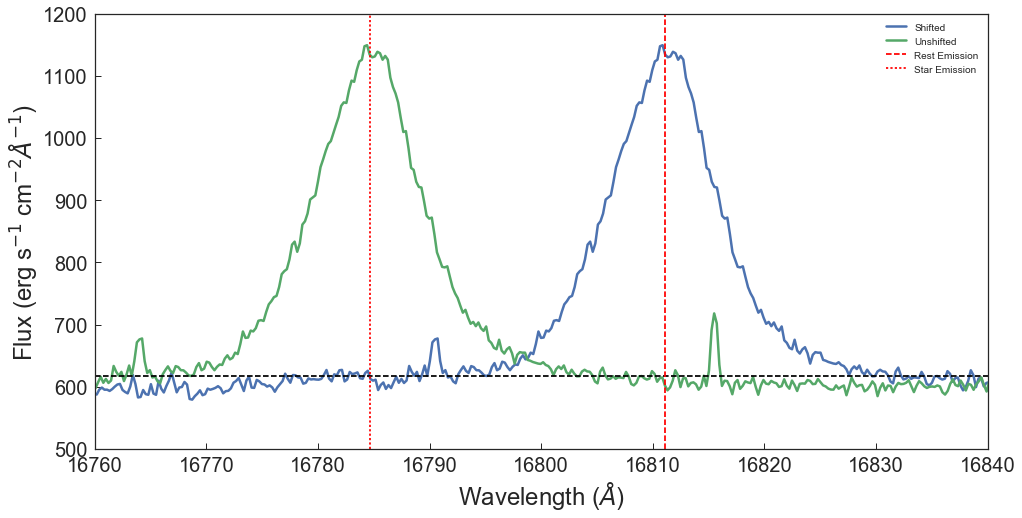

In [31]:
Brackett_EqW_Plot(4586,'2M03434449+3143092',11,16760,16840,500,1200)

## Shifted Spectra Examples

Below are several examples of good emission lines with both their unshifted and shifted spectra plotted.

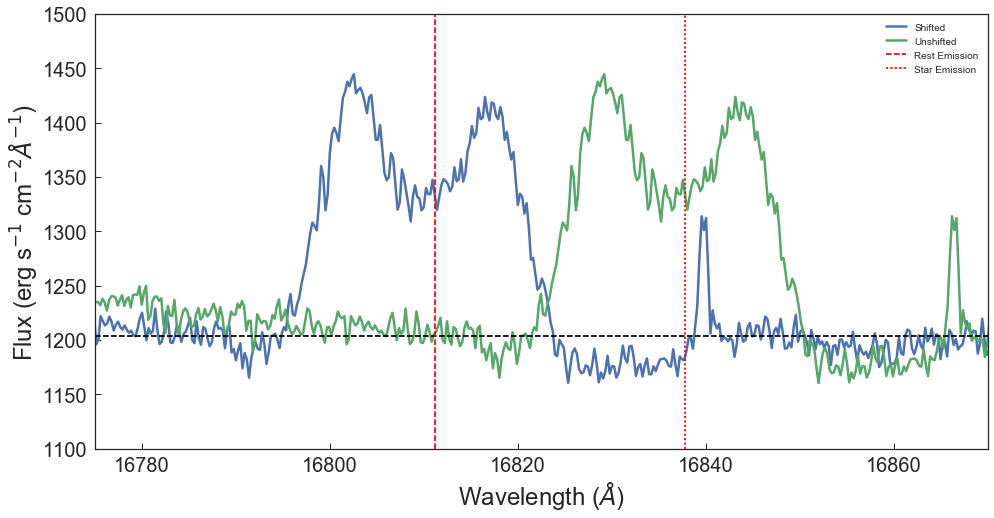

In [32]:
Brackett_EqW_Plot(4593,'2M05361555+3257145',11,16775,16870,1100,1500)

The plot for 2M06450343-0034140 (below) is an interesting case because neither the calculated rest wavelength or the shifted wavelength match up with their respective peaks. It doesn't seem to be a problem with the doppler shift itself as even the calculation for the rest wavelength seems to be wrong. This is something I'm going to look at.

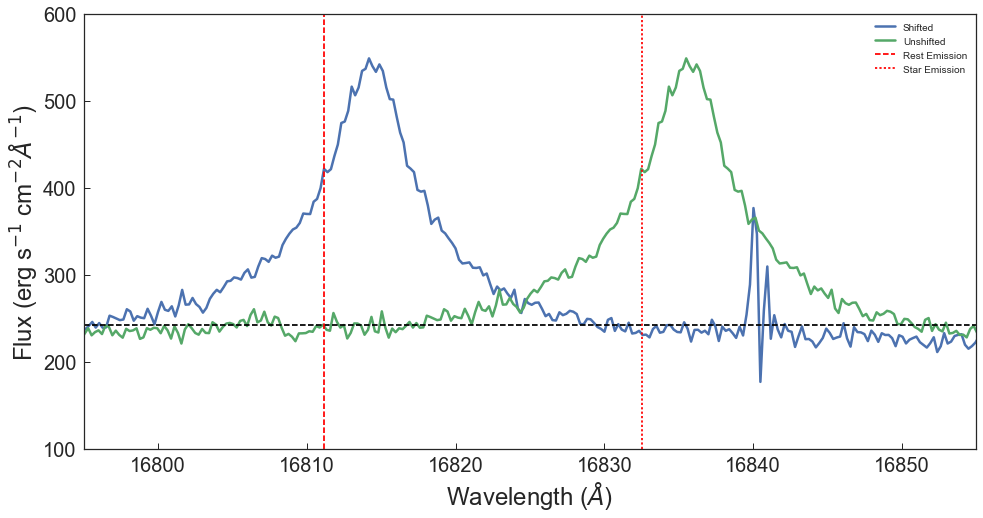

In [33]:
Brackett_EqW_Plot(4617,'2M06450343-0034140',11,16795,16855,100,600)

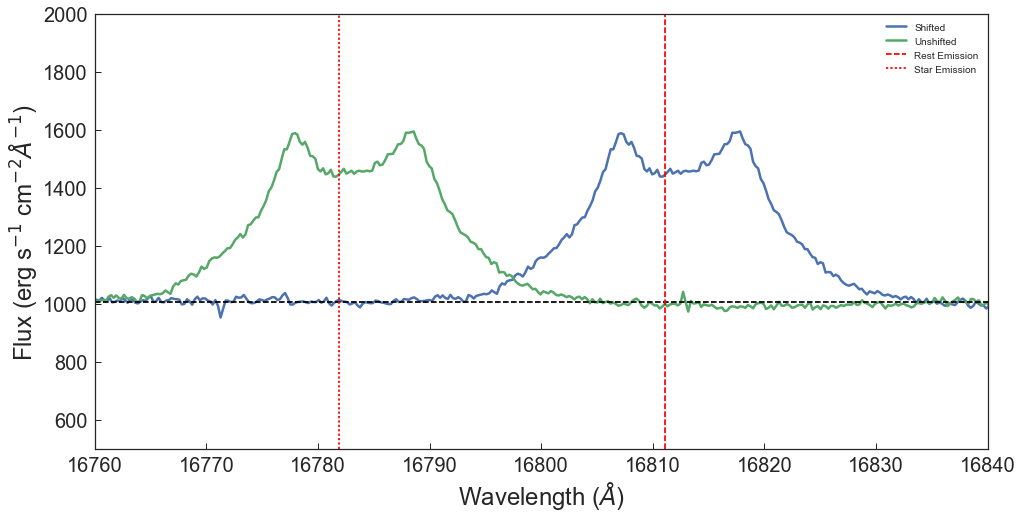

In [34]:
Brackett_EqW_Plot(4380,'2M18194176-1058093',11,16760,16840,500,2000)

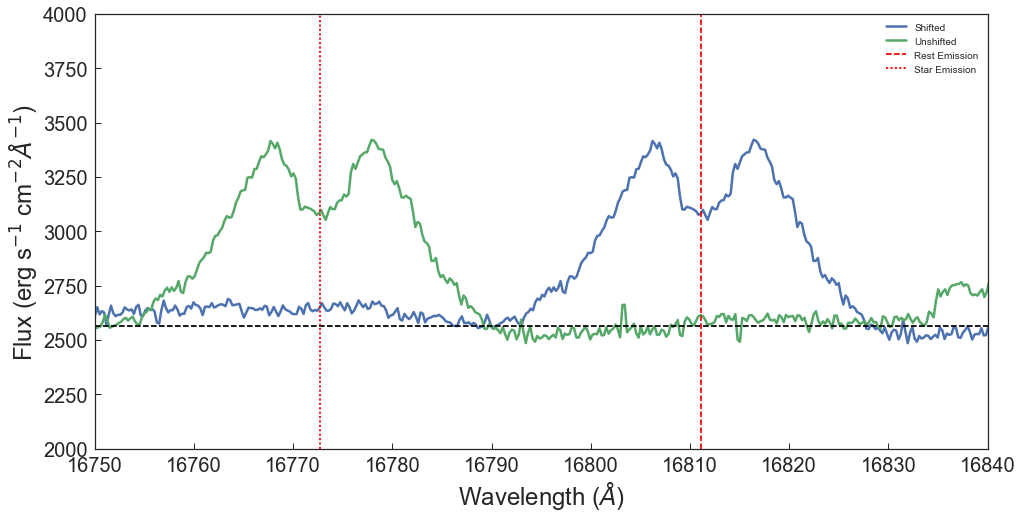

In [35]:
Brackett_EqW_Plot(4581,'2M06525305-1000270',11,16750,16840,2000,4000)

The velocity values for each plot from their headers are given in the table below (in order):

| Location ID | 2M ID              | VHELIO   | SVHELIO  | VRAD |
|:--------:|:------------------:|:--------:|:--------:|:----:|
|4586      | 2M03434449+3143092 | 472.223  | -354.991 | 0    | 
|4593      | 2M05361555+3257145 | -475.114 | 358.542  | 0    |
|4617      | 2M06450343-0034140 | -380.154 | 449.349  | 0    |
|4380      | 2M18194176-1058093 | 521.640  | -309.704 | 0    |
|4581      | 2M06525305-1000270 | 686.706  | 1306.57  | 0    |
